## Decision Trees

Decison trees are versatile Machine Learning algorithms that can perform both classification and regression tasks, they are very powerful algorithms, capable of fitting complex datasets. In this notes we will train, visualize and make predictions with Decision Trees, after that we will go trough the CART training algorithm used by Scikit-Learn and discuss how to regularize trees and use them for regression tasks. 

## Setup

First, let's import a few common modules

In [11]:
import sklearn
import numpy as np
import os
np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

## Training and visualizing a Decision Tree

Let's build one decision tree and take a look at how it makes predictions. The following code trains a DecisionTreeClassifier on the iris dataset

In [12]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [13]:
iris = load_iris()
X = iris.data[:,2:]
y = iris.target

In [14]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X,y)

DecisionTreeClassifier(max_depth=2)

To visualize the trained Decision Tree first we need to import export_graphviz() method to output a graph definition called iris_tree.dot

In [15]:
from graphviz import Source
from sklearn.tree import export_graphviz

In [16]:
export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

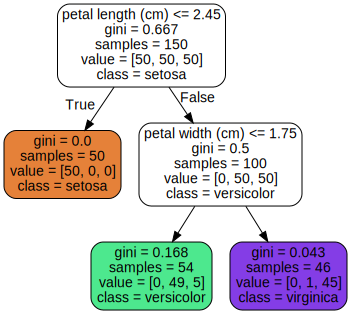

In [18]:
Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

## Making predictions

With this decision tree, if we find an iris flower and want to classify it. We start at the root node: the nood will ask whether the flower's petal length is smaller than 2.45 cm. If it is, then it will move down to the root's left child node (depth 1, left). In this case, it is a leaf node (because it does not have any child), the leaf does not ask further question and determine that the flower is an Iris-Setosa.

Now we find another flower, but this time the petal length is greater than 2.45 cm. In this case we move down to the root's right child node (depth 1, right), in this case it is not a leaf node, so it asks another question, is the petal width smaller than 1.75 cm? If it is, then your flower is most likely an Iris-Versicolor (depth 2, left). If not, it is likely an Iris-Virginica (depth 2, right).

### Gini Attribute

A metric to take in consideration is the gini attribute, which measures the purity of a node, if all instances belong to the same class, the gini metric is equal to zero or gini=0 and it's called a node pure. For this example the depth 1 left node applies only to Iris-Setosa training instances, it is pure and its gini score is 0.

Let's see in a graph how the Decision Tree works

In [35]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0,7.5,0,3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0],axes[1],100)
    x2s = np.linspace(axes[2],axes[3],100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contourf(x1,x2,y_pred,cmap=custom_cmap2,alpha=0.8)
    if plot_training:
        plt.plot(X[:,0][y==0], X[:,1][y==0], 'yo', label='Iris setosa')
        plt.plot(X[:,0][y==1], X[:,1][y==1], 'bs', label='Iris versicolor')
        plt.plot(X[:,0][y==2], X[:,1][y==2], 'g^', label='Iris virginica')
        plt.axis(axes)
    if iris:
        plt.xlabel('Petal length', fontsize=14)
        plt.ylabel('Petal width', fontsize=14)
    else:
        plt.xlabel('$x_1$', fontsize=18)
        plt.ylabel('$x_2$', fontsize=18, rotation=0)
    if legend:
        plt.legend(loc='lower right', fontsize=14)

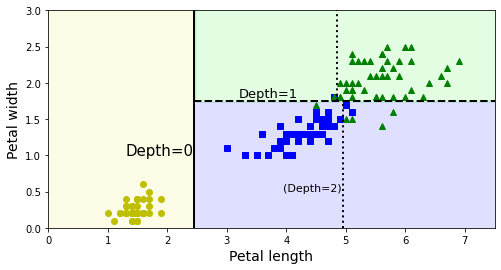

In [29]:
plt.figure(figsize=(8,4))
plot_decision_boundary(tree_clf,X,y)
plt.plot([2.45,2.45],[0,3],'k-',linewidth=2)
plt.plot([2.45,7.5],[1.75,1.75], 'k--',linewidth=2)
plt.plot([4.95,4.95],[0,1.75],'k:',linewidth=2)
plt.plot([4.85,4.85],[1.75,3],'k:',linewidth=2)
plt.text(1.30,1.0,'Depth=0',fontsize=15)
plt.text(3.2,1.8,'Depth=1',fontsize=13)
plt.text(3.95,0.5,'(Depth=2)',fontsize=11)
plt.show()

## Estimating Class Probabilities

A Decision Tree can estimate the probability that an instance belongs to a particular class $k$, first it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class $k$ in this node. 

For example, if we find a flower whose petals are 5 cm long and 1.5 cm wide. The corresponding leaf node is the depth-2 left node. So the Decision Tree should output the following probabilities: 0% for Iris-Setosa (0/54), 90.7% for Iris-Versicolor (49/54), and 9.3% for Iris-Virginica (5/54), and it will predict that it's an Iris-Versicolor since it has the highest proability.

In [30]:
tree_clf.predict_proba([[5,1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [31]:
tree_clf.predict([[5,1.5]])

array([1])

## Regularization Hyperparameters

Decision Trees make very few assumptions about the training data. If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely, and most likely overfitting it. This is called a nonparametric model, because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. This could lead to an overfit the model. 

To avoid the overfitting the training data, the Decision Tree's freedom needs to be restricted, this is called regularization. The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the Decision Tree. In Scikit-Learn, this is controlled by the max_depth hyperparameter.

In the following Figure two Decision Tree trained on the moons dataset are shown. On the left, the Decision Tree is trained with the default hyperparameters (no restrictions), and on the right the Decision Tree is trained with min_samples_leaf=4. The model on the left is overfitting and the left one generalize better.

In [32]:
from sklearn.datasets import make_moons

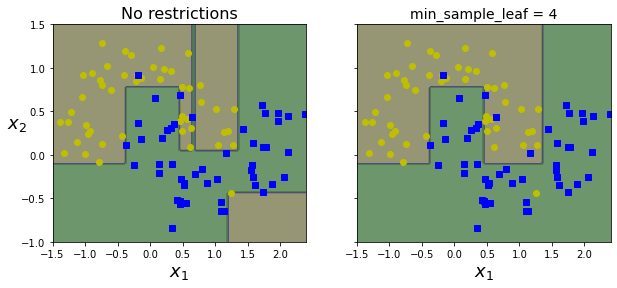

In [36]:
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm,ym)
deep_tree_clf2.fit(Xm,ym)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5,2.4,-1,1.5], iris=False)
plt.title('No restrictions', fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5,2.4,-1,1.5], iris=False)
plt.title('min_sample_leaf = 4',fontsize=14)
plt.ylabel('')
plt.show()

## Regression

Now let's try the Decision Tree algorithm into regression

In [37]:
np.random.seed(42)
m = 200
X = np.random.rand(m,1)
y = 4 * (X - 0.5) ** 2
y = y +np.random.randn(m,1) / 10

In [38]:
from sklearn.tree import DecisionTreeRegressor

In [39]:
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X,y)

DecisionTreeRegressor(max_depth=2, random_state=42)

The resulting tree is represented below

In [40]:
export_graphviz(
    tree_reg,
    out_file=os.path.join(IMAGES_PATH, 'regression_tree.dot'),
    feature_names=['x1'],
    rounded=True,
    filled=True
)

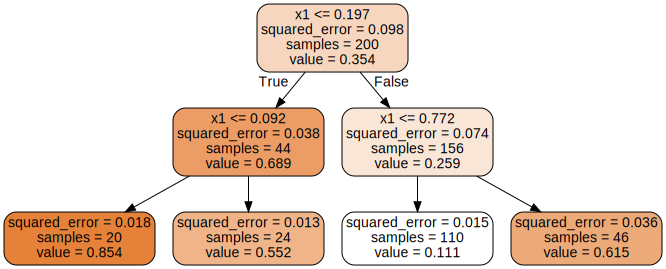

In [41]:
Source.from_file(os.path.join(IMAGES_PATH,'regression_tree.dot'))

The obtained tree is quite similar to the one obtained in the classification tree. The main difference is that instead of predicting a class in each node, it predicts a value. For example, suppose you want to make a prediction for a new instance with $x_1=0.6$. You traverse the tree starting at the root, and eventually reach the leaf node that predicts value=0.1106. This prediction is simply the average target value of the 110 training instances associated to this leaf node. But it has a Mean Squared Error (MSE) equal to 0.0151 over these 110 instances.

The models predictions are represented below 

Text(0.5, 1.0, 'max_depth=2')

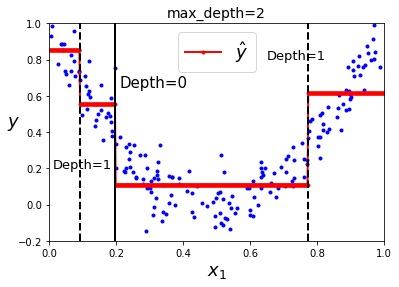

In [42]:
def plot_regression_predictions(tree_reg, X, y, axes=[0,1,-0.2,1], ylabel='$y$'):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1,1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel('$x_1$', fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, 'b.')
    plt.plot(x1, y_pred, 'r.-', linewidth=2, label=r'$\hat{y}$')

plot_regression_predictions(tree_reg, X, y)
for split, style in ((0.1973, 'k-'), (0.0917, 'k--'), (0.7718, 'k--')):
    plt.plot([split,split],[-0.2,1],style,linewidth=2)
plt.text(0.21,0.65,'Depth=0', fontsize=15)
plt.text(0.01, 0.2, 'Depth=1', fontsize=13)
plt.text(0.65, 0.8, 'Depth=1', fontsize=13)
plt.legend(loc='upper center', fontsize=18)
plt.title('max_depth=2', fontsize=14)

The CART algorithm works the same way as earlier, except that now tries to split the training set in a way that minimizes the MSE.

Just like for classification tasks, Decision Tree are prone to overfitting when dealing with regression tasks. Without any regularization, the predictions on the left are obtained, this is onviously overfitting the training set very badly. But with a min_samples_leaf=10 results in a much more reasonable model.

In [43]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X,y)
tree_reg2.fit(X,y)

DecisionTreeRegressor(min_samples_leaf=10, random_state=42)

In [44]:
x1 = np.linspace(0,1,500).reshape(-1,1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

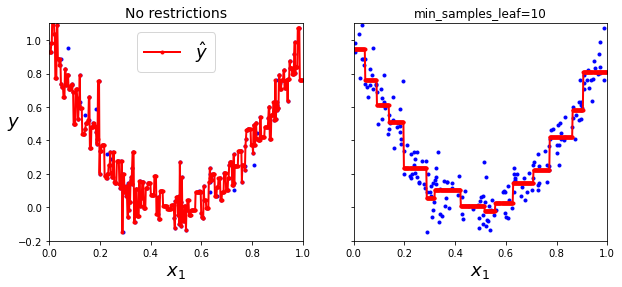

In [46]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, 'b.')
plt.plot(x1, y_pred1, 'r.-', linewidth=2, label=r'$\hat{y}$')
plt.axis([0,1,-0.2,1.1])
plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$y$',fontsize=18,rotation=0)
plt.legend(loc='upper center',fontsize=18)
plt.title('No restrictions', fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, 'b.')
plt.plot(x1, y_pred2, 'r.-', linewidth=2, label=r'$\hat{y}$')
plt.axis([0,1,-0.2,1.1])
plt.xlabel('$x_1$',fontsize=18)
plt.title('min_samples_leaf=10')

plt.show()